# TransUnet Model

## Module imoprts

In [1]:
# import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import os
import cv2
#import import_ipynb
import Utils
from tensorflow.keras import backend as K
# from skimage import util
import pickle

In [2]:
from tensorflow.keras import layers,losses,Sequential,metrics
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import optimizers 
from tensorflow.keras.optimizers import * 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
#import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from CBAM import ConvolutionBlockAttentionModule

## Reading the data

In [5]:
image_data = Utils.read_data("Berea_2d25um_binary.raw")
image_data.shape

(1000, 1000, 1000)

## Voxel Extraction

In [6]:
voxels = Utils.extract_subvolumes(image_data)
voxels.shape

(64, 250, 256, 256, 1)

In [7]:
del image_data

## Model Config

In [8]:
CONFIGURATION = {
    "BATCH_SIZE": 8,
    "LEARNING_RATE": 1e-3,
    "OPTIMIZER":'Adam',
    "PATCH_SIZE":16,
    "N_EPOCHS": 2,
    "N_FILTERS": 5,
    "INPUT_SHAPE":(256,256,1),
    "LATENT_SPACE_DIM" : 64,
    "REDUCED_DIMENSION" : 256,
    "N_HEADS" : 3,
    "HIDDEN_SIZE" : 256,
    "N_PATCHES" : 256,
    "N_LAYERS" : 1,
}

## Loss functions

In [9]:
def calculate_kl_loss(model):
    def _calculate_kl_loss(*args):
        kld = tf.keras.losses.KLDivergence()
        kl_loss = kld(model.inferenceDistribution,model.learnedDistribution)
        return tf.abs(kl_loss)
    return _calculate_kl_loss

def _calculate_reconstruction_loss(y_target, y_predicted):
    mse = losses.MeanSquaredError()
    reconstruction_loss = mse( y_target, y_predicted )
    return reconstruction_loss


def _calculate_porosity_loss(y_target,y_predicted):
    por1 = tf.reduce_mean(y_target,axis=(1, 2))
    por2 = tf.reduce_mean(y_predicted,axis=(1, 2))
    mae = losses.MeanAbsoluteError()
    return mae(por1,por2)
    

## Model Class

### Transformer Architecture

#### Patch Encoder

In [10]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')
    
    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))
    
    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
    
    return output

#### Transformer Encoder

In [11]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()
    
    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )
    
    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    
  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

#### Vision Transformer

In [12]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS*2, 'gelu',kernel_initializer='glorot_uniform')
    self.mu = Dense(N_DENSE_UNITS, activation = 'sigmoid',kernel_initializer='glorot_uniform')
    self.sigma = Dense(N_DENSE_UNITS, activation = 'sigmoid',kernel_initializer='glorot_uniform')
  def sample_z(self,args):
      z_mu, z_sigma = args
      eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
      return z_mu + K.exp(z_sigma / 2) * eps
  def call(self, inputs, training = True):

    x = self.patch_encoder(inputs)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    mu = self.mu(x)
    sigma = self.sigma(x)
    z = Lambda(self.sample_z, output_shape=(64, ), name='z')([mu, sigma])
    return z

##### ViT Example

In [13]:
# vit = ViT(
#     N_HEADS = 4, HIDDEN_SIZE = 256, N_PATCHES = 256,
#     N_LAYERS = 2, N_DENSE_UNITS = 64)
# vit(tf.zeros([1,256,256,1]))

In [14]:

# vit.summary()

In [15]:
class Reconstruction():
    """
    Reconstruction represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 inputShape=CONFIGURATION["INPUT_SHAPE"],
                 latent_space_dim = CONFIGURATION["LATENT_SPACE_DIM"],
                 reducedDimension = CONFIGURATION["REDUCED_DIMENSION"],
                 num_conv_layers = CONFIGURATION["N_FILTERS"],
                 learning_rate = CONFIGURATION["LEARNING_RATE"],
                 batch_size = CONFIGURATION["BATCH_SIZE"],
                 epochs = CONFIGURATION["N_EPOCHS"],
                 opt = CONFIGURATION["OPTIMIZER"],
                 n_heads =   CONFIGURATION["N_HEADS"], 
                  hidden_size =  CONFIGURATION["HIDDEN_SIZE"],
                  n_patches =  CONFIGURATION["N_PATCHES"],
                  enc_layers =  CONFIGURATION["N_LAYERS"],
                )-> None:
        
        
        
        ##### inputs ######
        self.inputShape = inputShape # [256, 256, 1]
        self.latent_space_dim = latent_space_dim # 64
        self.reducedDimension = reducedDimension #256
        self.num_conv_layers = num_conv_layers #5
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.opt = opt
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.n_patches = n_patches
        self.enc_layers = enc_layers
        self.optimizers = {
            'SGD' : SGD, 
            'RMSprop' : RMSprop,
            'Adagrad' : Adagrad,
            'Adadelta' : Adadelta,
            'Adam' : Adam,
            'Adamax' : Adamax,
            'Nadam' : Nadam,
        }
        self.reshapeDims = self.inputShape[0] // 2**self.num_conv_layers
        self.last_filter = 16 * 2 ** (self.num_conv_layers-1)
        
        
        
        ##### Loss weights ######
        self.reconstruction_loss_weight = 1
        self.Kullback_leibler_weight = 0.001
        self.porosity_Loss_weight = 1
        
        self.skipConnections = []

        self.learnedPrior = None
        self.inference = None
        self.Generate = None
        self.Reconstruction=None

        
        
        self.learnedDistribution = None
        self.inferenceDistribution = None
        
        self._build()

    def summary(self):
        self.learnedPrior.summary()
        self.inference.summary()
        self.Generate.summary()
        self.Reconstruction.summary()
        
    def compile(self):
        optimizer = self.optimizers[self.opt](learning_rate=self.learning_rate)
        self.Reconstruction.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[_calculate_reconstruction_loss,
                                    _calculate_porosity_loss,
                                    calculate_kl_loss(self)],
                             experimental_run_tf_function=False)
    
    def train(self, inputs1,inputs2):
        return self.Reconstruction.fit(x=[inputs1,inputs2],
                       y=inputs2,
                       batch_size=self.batch_size,
                       epochs=self.epochs,
                       )
    
    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.Reconstruction.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations
    
    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        reconstruction = Reconstruction(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        reconstruction.load_weights(weights_path)
        return reconstruction

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.inputShape,
            self.latent_space_dim,
            self.reducedDimension,
            self.num_conv_layers,
            self.learning_rate,
            self.batch_size,
            self.epochs,
            self.opt,
            self.n_heads,
            self.hidden_size,
            self.n_patches,
            self.enc_layers,
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.Reconstruction.save_weights(save_path)

    def _calculate_combined_loss(self, y_target, y_predicted):
        
        
        reconstruction_loss = _calculate_reconstruction_loss(y_target,y_predicted)
        kl_loss = calculate_kl_loss(self)(self.inferenceDistribution, self.learnedDistribution)
        porisity_loss = _calculate_porosity_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss * self.Kullback_leibler_weight\
                                                         + porisity_loss * self.porosity_Loss_weight
        return combined_loss
    


    def _build(self):
        self._build_inference()
        self._build_learned_prior()
        self._build_generate(self.num_conv_layers)

        self._build_reconstruction()

    ######  inference ########
    
    
        
    def _build_inference(self):
        self.inference = ViT(
        N_HEADS = self.n_heads, HIDDEN_SIZE = self.hidden_size, N_PATCHES = self.n_patches,
        N_LAYERS = self.enc_layers, N_DENSE_UNITS = self.latent_space_dim)
        
        
    ######   learned prior ########
        
    def _build_learned_prior(self):
        
        self.learnedPrior =ViT(
        N_HEADS = self.n_heads, HIDDEN_SIZE = self.hidden_size, N_PATCHES = self.n_patches,
        N_LAYERS = self.enc_layers, N_DENSE_UNITS = self.latent_space_dim)
    
    #### generate ######
    
    def _build_generate(self,num_conv_layers):
        

        
        input_generate = layers.Input(shape=self.inputShape, name="generate_input")
        learnedDist = layers.Input(shape=(1,self.latent_space_dim), name="gen_learned_input")
        
        ### ------------------------------------ Encoder ---------------------------------------------
        
        x = input_generate
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu', padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp
            self.skipConnections.append(bn)

        
        flattened = layers.Flatten()(x)
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        
        conv_out = layers.Reshape(( 1 ,self.reducedDimension ),name="reshape_conv")(conv_out)
#         learnedDist = layers.Reshape(( 1 ,self.latent_space_dim ),name="reshape_learned")(learnedDist)
        
        
        concated_input = layers.Concatenate(axis=-1)([conv_out,learnedDist])
        
        reshaped = layers.Reshape((1, self.reducedDimension + self.latent_space_dim),name="reshape_all")(concated_input)
        
        generated = layers.LSTM(self.reducedDimension, return_sequences=True,name="generate_LSTM")(reshaped)
        
        upDense = layers.Dense(self.reshapeDims*self.reshapeDims*self.last_filter,name="up_dense")(generated)
        batchNorm_7 = layers.BatchNormalization()(upDense)
        
        reshapedUp = layers.Reshape((self.reshapeDims,self.reshapeDims,self.last_filter))(batchNorm_7)
        
        generated = reshapedUp
        for i in reversed(range(num_conv_layers)):
            convT = layers.Conv2DTranspose(16 * 2 ** i, (3, 3), strides=2, activation='relu',
                                           padding='same', name=f"decoder_conv_{i+1}")(generated)
            bn = layers.BatchNormalization()(convT)
            skip_conn = self.skipConnections.pop()
            bn = layers.Add()([bn, skip_conn])
            generated = ConvolutionBlockAttentionModule()(bn)
        
        
        gen_out = layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')(generated)
        
        self.Generate = Model([input_generate,learnedDist], gen_out, name="generate")
        
        
    def _build_reconstruction(self):
        input_learned = layers.Input(shape=self.inputShape, name="learned_input")
        input_inference = layers.Input(shape=self.inputShape, name="inference_input")



        self.learnedDistribution = self.learnedPrior(input_learned)
        self.learnedDistribution = layers.Reshape(( 1 ,self.latent_space_dim ))(self.learnedDistribution)
        self.inferenceDistribution = self.inference(input_inference)
        gen_out = self.Generate([input_learned,self.learnedDistribution])

        self.Reconstruction = Model([input_learned,input_inference],gen_out,name="reconstuction")

## TensorFlow gpu setup

In [16]:
device = tf.config.list_physical_devices("GPU")
print(device)
tf.config.experimental.set_memory_growth(device[0],True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [18]:
tf.keras.backend.clear_session()

In [19]:
reconstruction = Reconstruction()
reconstruction.summary()
reconstruction.compile()
batch_size = 10
epochs = 10

# for voxel in X_train:
#     reconstruction.train(voxel, batch_size, epochs)

Instructions for updating:
Colocations handled automatically by placer.
Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_encoder (PatchEncoder) (None, 256, 256)          131328    
_________________________________________________________________
transformer_encoder (Transfo (None, 256, 256)          921600    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
Total params: 9,458,176
Trainable params: 9,458,176
Non-trainable params: 0
_________________________________________________________________
Model: "vision_transformer"
____

In [20]:
import scipy
print(scipy.__version__)

1.10.1


## Model creation

## train and test data extraction

In [21]:
X_train = voxels[:-6]
X_test = voxels[-6:]

In [22]:
import numpy as np
print(np.__version__)

1.19.5


In [23]:
del voxels

## Creating model input


In [24]:
learnedVoxels = []
inferenceVoxels = []
for voxel in X_train:
    learnedVoxels.append(voxel[:-1])
    inferenceVoxels.append(voxel[1:])

# learnedVoxels = np.array(learnedVoxels)
# inferenceVoxels = np.array(inferenceVoxels)


In [25]:
import sys
from mealpy.swarm_based import GWO
from sklearn.preprocessing import LabelEncoder


OPT_ENCODER = LabelEncoder()
#OPT_ENCODER.fit(['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'])
OPT_ENCODER.fit(['SGD', 'RMSprop', 'Adagrad', 'Adam'])


def decode_solution(solution):
    batch_size = 2**int(solution[0])
    
    learning_rate = solution[1]
    
    opt_int = int(solution[2])
    opt = OPT_ENCODER.inverse_transform([opt_int])[0]
    
    epoch = 10 *int(solution[3])
    
    num_filters = int(solution[4])
    
    latent_space_dim = 2**int(solution[5])
    
    reduced_dim = 2**int(solution[6])
    
    n_heads  = int(solution[7]) 
    hidden_size = 2** int(solution[8])
    enc_layers =  int(solution[9])
    
    return [batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim,reduced_dim,n_heads,hidden_size,enc_layers]


def objective_function(solution):
    tf.keras.backend.clear_session()
    batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim ,reduced_dim,n_heads,hidden_size,enc_layers = decode_solution(solution)
    reconstruction = Reconstruction(inputShape=CONFIGURATION["INPUT_SHAPE"],
                                     latent_space_dim = latent_space_dim,
                                     reducedDimension = reduced_dim,
                                     num_conv_layers = num_filters,
                                     learning_rate = learning_rate,
                                     batch_size = batch_size,
                                     epochs = epoch,
                                     opt = opt,
                                     n_heads =   n_heads, 
                                     hidden_size =  hidden_size,
                                     enc_layers =  enc_layers,
                                   )
#     reconstruction.summary()
    
    reconstruction.compile()
    
    histories = []
    for i in range(len(learnedVoxels)):
        print(f"currently working one voxel : {i +1}, voxels left : {len(learnedVoxels)-(i+1)} ")
        histories.append(reconstruction.train(learnedVoxels[i],inferenceVoxels[i]))
    
    reconstruction.save(save_folder=f"model_{batch_size}_{learning_rate}_{opt}_{epoch}_{num_filters}_{latent_space_dim}_{reduced_dim}_{n_heads}_{hidden_size}_{enc_layers}")

    return histories[-1].history['loss'][-1]


LB = [3    , 0.001 , 0   , 2      ,  4  ,  6    , 7   , 3   , 6 ,  2 ,    6 ]
UB = [5.99 , 0.01  , 3.99, 4.99  ,  8.99,  8.99 , 9.99, 5.99, 7.99, 4.99, 8.99 ]

problem_dict = {
    "fit_func": objective_function,
    "lb": LB,
    "ub": UB,
    "minmax": "min",
    "verbose":True,
}

model = GWO.BaseGWO(problem_dict,epoch=5,pop_size=50)
model.solve()
print(f"Best solution : {model.solution[0]}")
batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim ,reduced_dim = decode_solution(model.solution[0])
print(f"Batch size : {batch_size}, learning_rate : {learning_rate}, opt : {opt}, epoch : {epoch}, num_filters : {num_filters}, latent_space_dim : {latent_space_dim}, reduced_dim : {reduced_dim}")
model.history.save_global_objectives_chart(filename="hello/goc")
model.history.save_local_objectives_chart(filename="hello/loc")

model.history.save_global_best_fitness_chart(filename="hello/gbfc")
model.history.save_local_best_fitness_chart(filename="hello/lbfc")

model.history.save_runtime_chart(filename="hello/rtc")

model.history.save_exploration_exploitation_chart(filename="hello/eec")

model.history.save_diversity_chart(filename="hello/dc")

model.history.save_trajectory_chart(list_agent_idx=[3, 5], selected_dimensions=[3], filename="hello/tc")

currently working one voxel : 1, voxels left : 57 
Train on 249 samples
Epoch 1/20
249/249 [==============================] - 15s 61ms/sample - loss: 0.4210 - _calculate_reconstruction_loss: 0.0698 - _calculate_porosity_loss: 0.0659 - _calculate_kl_loss: 281.3186
Epoch 2/20
249/249 [==============================] - 2s 8ms/sample - loss: 0.2553 - _calculate_reconstruction_loss: 0.0291 - _calculate_porosity_loss: 0.0051 - _calculate_kl_loss: 220.5856
Epoch 3/20
249/249 [==============================] - 2s 8ms/sample - loss: 0.2507 - _calculate_reconstruction_loss: 0.0284 - _calculate_porosity_loss: 0.0041 - _calculate_kl_loss: 218.1498
Epoch 4/20
249/249 [==============================] - 2s 8ms/sample - loss: 0.2473 - _calculate_reconstruction_loss: 0.0283 - _calculate_porosity_loss: 0.0035 - _calculate_kl_loss: 215.4030
Epoch 5/20
249/249 [==============================] - 2s 8ms/sample - loss: 0.2512 - _calculate_reconstruction_loss: 0.0280 - _calculate_porosity_loss: 0.0026 - _calc

2023/06/17 02:43:09 PM, INFO, mealpy.swarm_based.GWO.BaseGWO: Solving single objective optimization problem.


currently working one voxel : 1, voxels left : 57 
Train on 249 samples
Epoch 1/20
249/249 [==============================] - 8s 33ms/sample - loss: 0.4694 - _calculate_reconstruction_loss: 0.0894 - _calculate_porosity_loss: 0.0795 - _calculate_kl_loss: 295.8387
Epoch 2/20
249/249 [==============================] - 2s 9ms/sample - loss: 0.2959 - _calculate_reconstruction_loss: 0.0287 - _calculate_porosity_loss: 0.0051 - _calculate_kl_loss: 262.4190
Epoch 3/20
249/249 [==============================] - 2s 9ms/sample - loss: 0.2958 - _calculate_reconstruction_loss: 0.0276 - _calculate_porosity_loss: 0.0045 - _calculate_kl_loss: 263.9651
Epoch 4/20
249/249 [==============================] - 2s 9ms/sample - loss: 0.2946 - _calculate_reconstruction_loss: 0.0275 - _calculate_porosity_loss: 0.0046 - _calculate_kl_loss: 262.4476
Epoch 5/20
249/249 [==============================] - 2s 9ms/sample - loss: 0.2931 - _calculate_reconstruction_loss: 0.0275 - _calculate_porosity_loss: 0.0047 - _calcu

## Training the model

In [129]:
histories = []
for i in range(3):
    print(f"currently working one voxel : {i +1}, voxels left : {3-(i+1)} ")
    histories.append(reconstruction.train(learnedVoxels[i],inferenceVoxels[i]))

currently working one voxel : 1, voxels left : 2 
Train on 249 samples
Epoch 1/2
249/249 [==============================] - 12s 46ms/sample - loss: 0.2337 - _calculate_reconstruction_loss: 0.0740 - _calculate_porosity_loss: 0.0176 - _calculate_kl_loss: 141.3014
Epoch 2/2
249/249 [==============================] - 7s 28ms/sample - loss: 0.1655 - _calculate_reconstruction_loss: 0.0282 - _calculate_porosity_loss: 0.0011 - _calculate_kl_loss: 137.6476
currently working one voxel : 2, voxels left : 1 
Train on 249 samples
Epoch 1/2
249/249 [==============================] - 7s 29ms/sample - loss: 0.1623 - _calculate_reconstruction_loss: 0.0261 - _calculate_porosity_loss: 6.3037e-04 - _calculate_kl_loss: 134.3341
Epoch 2/2
249/249 [==============================] - 7s 28ms/sample - loss: 0.1652 - _calculate_reconstruction_loss: 0.0245 - _calculate_porosity_loss: 3.6316e-04 - _calculate_kl_loss: 141.6102
currently working one voxel : 3, voxels left : 0 
Train on 249 samples
Epoch 1/2
249/249 

In [132]:
reconstruction.save(save_folder="test2")

In [25]:
saved = Reconstruction.load(save_folder=f"model_32_0.0069123020082199095_Adagrad_30_5_64_128_5_64_3")

## Testing the model

In [26]:

first  = X_test[0]
Topredict = first[1:]
test = first[:-1]


In [27]:
predicted = []


# for i in range(10):
predicted = reconstruction.Generate.predict([test,Topredict])
# predicted.append(nextLayer)
# #     inputLayer = nextLayer
# predicted.append()

ValueError: Error when checking input: expected gen_learned_input to have 3 dimensions, but got array with shape (249, 256, 256, 1)

In [28]:
len(predicted)

0

IndexError: list index out of range

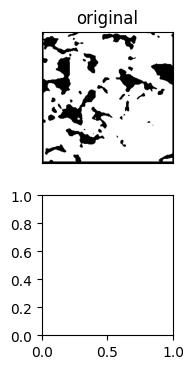

In [29]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(predicted[i])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [66]:
testing = []
inputLayer = test[0]
for i in range(10):
    testing.append(reconstruction.Generate.predict([inputLayer.reshape(1,256,256,1),Topredict[i].reshape(1,256,256,1)]))
    inputLayer = testing[-1]

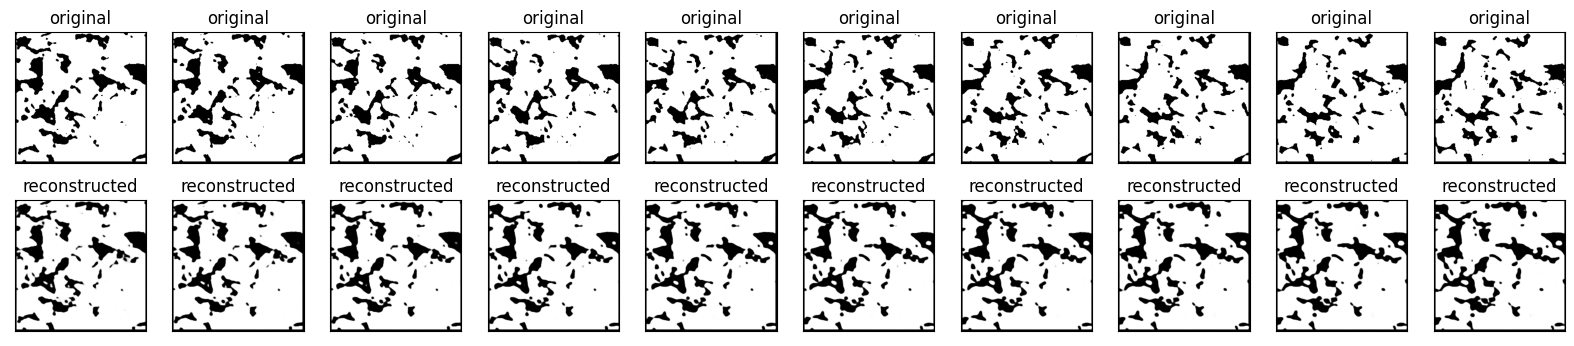

In [67]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)